In [1]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') 

cwd = %pwd

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [9]:
import pandas as pd
import numpy as np
import rdkit
import matplotlib.pyplot as plt

# Run Training

In [6]:
%cd $cwd
%cd Real-ChemTS/train_RNN/
%run train_RNN.py

/home/zhang/elix
/home/zhang/elix/Real-ChemTS/train_RNN


#### Note: After training, you need to copy the content of Real-ChemTS/train_val.txt into __main__ function, and replace the contain of val = [ ... ]. This is a long-time existing annoying point for ChemTS, I know. 

Here in training, we used 7111 selected smiles from ChEMBL dataset, to make the molecule generated similar to the ChEMBL dataset. Depends on our previous experiences, ChEMBL dataset for erbb1 contains molecules that are designed or related to erbb1 receptor, which makes its affinity distribution largly different with the other dataset. In another word, this set contains molecules that has a low ic50. Training on such dataset is desirable. 


However, the way I did the training (train directly on erbb1 dataset) is not optimal. The optimal solution should be: first train on a drug-like dataset such as ZINC drug-like, and then refine the training on erbb1 dataset.

The reason is that, we should first train RNN to learn about different chemical grammar and substructure on a larger dataset, such as ZINC. And after that, we can refine the molecule generation by retraining several epochs on low ic50 molecule set.

Only training on low ic50 molecule set will let the model miss several grammar or substructure that is uncommon in this dataset due to its size.

Unfortuanatly due to timing issue, I am only able to proceed with this simple solution

# Run Generation

In [ ]:
%cd $cwd
%cd Real-ChemTS/ChemTS
%run mcts_logp.py

# Visualization of generated distribution

In [41]:
%cd $cwd
file_list = ['Real-ChemTS/data/chemts_eva_out_652.txt']
for file in file_list:
    smiles_dict = {}
    chemts_score_list = []
    chemts_smiles_list = []
    unique = 0
    valid = 0
    total_line = 0
    with open(file, 'r') as f:
        for line in f.readlines():
            if '|' in line:
                total_line += 1
                smiles, score = line.split('|')
                if smiles not in smiles_dict:
                    smiles_dict[smiles] = score
                    unique += 1
                if "None" not in score:
                    chemts_score_list.append(float(score))
                    chemts_smiles_list.append(smiles)
                    valid += 1
            elif 'None' in line:
                total_line += 1

/home/zhang/elix


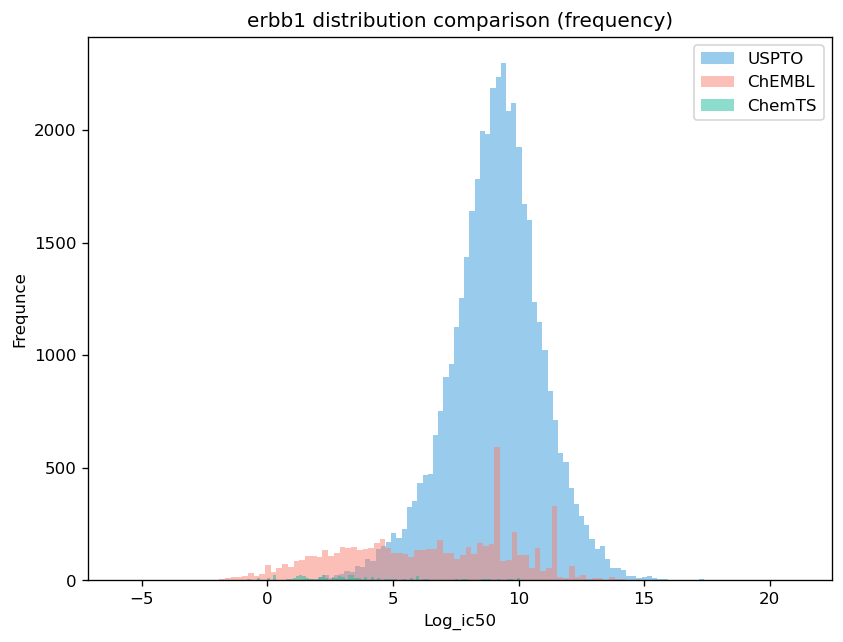

In [36]:

chembl_df = pd.read_csv('rxngenerator/erbb1_log_50.csv', sep = ',', names = ['smiles', 'log_ic50'])

file = 'rxngenerator/USPTO_res.txt'
plt.figure(figsize=(8, 6), dpi=120)
smiles_dict = {}
score_list = []
unique = 0
valid = 0
with open(file, 'r') as f:
    for line in f.readlines():
        if '|' in line:
            smiles, score = line.split('|')
            if smiles not in smiles_dict:
                smiles_dict[smiles] = score
                unique += 1
            if "None" not in score:
                score_list.append(float(score))
with open(file, 'r') as f:
    for line in f.readlines():
        if '|' in line:
            smiles, score = line.split('|')
            if smiles not in smiles_dict:
                smiles_dict[smiles] = score
                unique += 1
            if "None" not in score:
                score_list.append(float(score))
plt.hist(score_list, bins = 100, color = '#3498DB', alpha = 0.5, label = 'USPTO')
plt.hist(chembl_df['log_ic50'],bins = 100, color = '#FA8072', alpha = 0.5, label = 'ChEMBL')
plt.hist(chemts_score_list, bins = 100, color = '#1ABC9C', alpha = 0.5, label = 'ChemTS')
plt.legend(loc = 'best')
plt.xlabel('Log_ic50')
plt.ylabel('Frequnce')
plt.title('erbb1 distribution comparison (frequency)')
plt.show()

#### Desity plot:

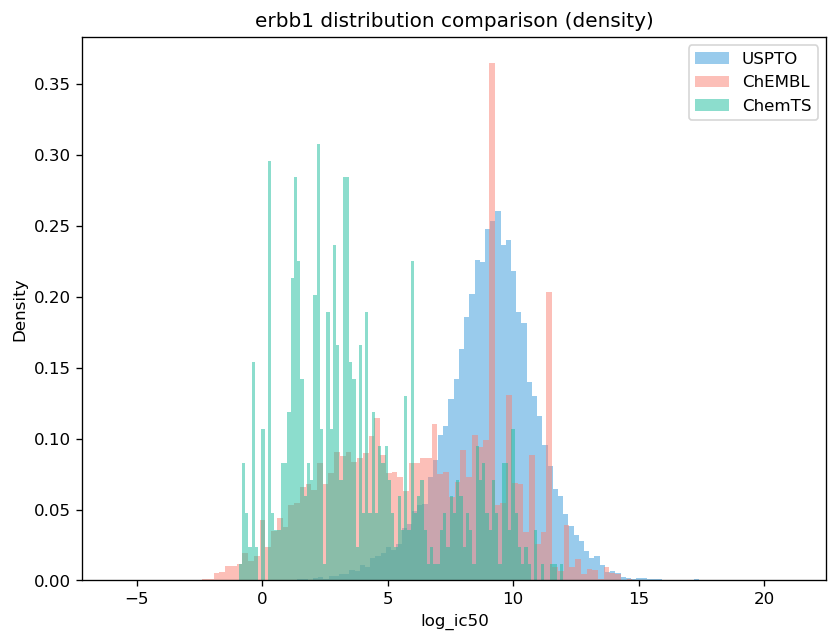

In [37]:
plt.figure(figsize=(8, 6), dpi=120)
plt.hist(score_list, bins = 100, color = '#3498DB', alpha = 0.5, label = 'USPTO', density = True)
plt.hist(chembl_df['log_ic50'],bins = 100, color = '#FA8072', alpha = 0.5, label = 'ChEMBL', density = True)
plt.hist(chemts_score_list, bins = 100, color = '#1ABC9C', alpha = 0.5, label = 'ChemTS', density = True)
plt.legend(loc = 'best')
plt.xlabel('log_ic50')
plt.ylabel('Density')
plt.title('erbb1 distribution comparison (density)')
plt.show()

# Top 10 Candidates

In [27]:
candidate_df = pd.DataFrame({'smiles':chemts_smiles_list, 'log_ic50':chemts_score_list})
candidate_df['ic50'] = np.exp(candidate_df['log_ic50'])

In [29]:
pd.set_option('display.max_colwidth', None)
candidate_df.sort_values(by = ['log_ic50']).drop_duplicates(keep = 'first').head(10)

,smiles,log_ic50,ic50
202,FC(OC)Cc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCCCn1ccnc1[N+](=O)[O-],-0.934006,0.392976
218,O=Cc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,-0.715218,0.489086
338,Brc1cc(Nc2ccc3ncnc(Nc4cccc(Br)c4)c3c2)ccc1Cl,-0.701835,0.495675
638,O=Cc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cn1,-0.630862,0.532133
2,Fc1ncc2ncnc(Nc3cccc(Br)c3)c2n1,-0.593302,0.552500
501,FC(OC)Cc1cc2sc3c(Nc4cccc(Br)c4)ncnc3c2cc1.O,-0.526602,0.590608
365,O=Cc1cc2ncnc(Nc3cccc(F)c3)c2cn1,-0.446836,0.639649
563,FC(OC)Cc1cc2ncnc(Nc3cccc(Br)c3)c2cn1,-0.386476,0.679447
509,FC(OC)Cc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,-0.339407,0.712193
549,FC(OC)Cc1cc2sc3c(Nc4cccc(Br)c4)ncnc3c2nc1.Cl,-0.337540,0.713523


# Uniqueness, Novolty and Validity

In [32]:
print('Uniqueness:', len(candidate_df['smiles'].drop_duplicates()) / len(candidate_df))

Uniqueness: 0.6309341500765697


In [33]:
novol_smiles_count = 0
for smiles in chemts_smiles_list:
    if smiles not in chembl_df['smiles'].values:
        novol_smiles_count += 1

print('Novolty:', novol_smiles_count / len(candidate_df))

Novolty: 1.0


In [42]:
print('Validity:', valid / total_line)

Validity: 0.6725025746652935


# Summary

We believe ChemTS is the most effective generative model in terms of optimizing erbb1 affinity amoung all 3 models tested. However, the synthesizability of these generated molecules are still questionable. 